In [ ]:
!unzip /content/drive/MyDrive/APS360Project/archive/cropped_dataset/A.zip

In [1]:
# initialization
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd
from matplotlib.image import imread
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [3]:
print(len(total_info['image_id']))
print(len(train_info['image_id']), len(train_info['image_id'])/len(total_info['image_id']))
print(len(val_info['image_id']), len(val_info['image_id'])/len(total_info['image_id']))
print(len(test_info['image_id']), len(test_info['image_id'])/len(total_info['image_id']))

12848
9616 0.7484433374844334
1616 0.12577833125778332
1616 0.12577833125778332


In [4]:
classes = pd.read_csv(class_dict_path)
list(classes['name'])

['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']

In [5]:
class DataFull(object):  # Class names typically use CamelCase
    def __init__(self, csv_info, image_folder_path, transform_input, transform_output):
        self.img_info = csv_info
        self.image_folder_path = image_folder_path
        self.transform_input = transform_input
        self.transform_output = transform_output

    def __len__(self):
        return len(self.img_info)  # Assuming img_info is a DataFrame or similar structure

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][idx])
        image = read_image(img_path)
        label_path = os.path.join(self.image_folder_path, self.img_info['mask_path'][idx])
        label = read_image(label_path)
        if self.transform_input:
            image = self.transform_input(image)
        if self.transform_output:
            label = self.transform_output(label)
        return image, label

In [84]:
mean= [0.4112, 0.3803, 0.2822]
std= [0.1094, 0.0850, 0.0718]
# tensor([0.4112, 0.3803, 0.2822]) tensor([0.1094, 0.0849, 0.0718])

transform_input = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         #transforms.Normalize(mean, std),
         transforms.Resize((256,256))])

transform_output = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Resize((256,256))])

train_dataset = DataFull(train_info, image_folder_path, transform_input, transform_output)
val_dataset = DataFull(val_info, image_folder_path, transform_input, transform_output)
test_dataset = DataFull(test_info, image_folder_path,transform_input, transform_output)

In [85]:
train_set = []
val_set = []
test_set = []

for i in range(int(len(train_info))):  # Assuming train_dataset is an instance of DataFull
    image, label = train_dataset[i]  # Use subscript notation
    train_set.append((image, label))
    print(i)
print("finish train set")

for i in range(int(len(val_info))):
  image, label = val_dataset[i]
  val_set.append((image, label))
print("finish val set")

for i in range(int(len(test_info))):
  image, label = test_dataset[i]
  test_set.append((image, label))
print("finish test set")

Streaming output truncated to the last 5000 lines.
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808

In [ ]:
print(train_set[0])

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [95]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
k = 0
for i, data in enumerate(train_loader, 0):
    k = k+1
    inputs, labels = data
    print(inputs, labels)
    if k == 1:
        break

In [96]:
def model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


In [97]:
def train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device):
    autoencoder.to(device)
    autoencoder.train()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("Training Start:")
    start_time = time.time()
    for epoch in range(num_epochs):
        # Training
        running_train_loss = 0.0
        total_pixels_train = 0
        correct_pixels_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = autoencoder(inputs).to(device)
            batch_loss = criterion(outputs, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()

            running_train_loss += batch_loss.item()

            # Calculate accuracy
            total_pixels_train += inputs.numel()
            correct_pixels_train += torch.sum(torch.abs(outputs - labels) < 0.05).item()

        train_accuracy = correct_pixels_train / total_pixels_train
        train_accuracies.append(train_accuracy)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        autoencoder.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        total_pixels_val = 0
        correct_pixels_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)
                outputs_val = autoencoder(inputs_val).to(device)
                val_loss = criterion(outputs_val, labels_val)
                running_val_loss += val_loss.item()

                # Calculate accuracy
                total_pixels_val += inputs_val.numel()
                correct_pixels_val += torch.sum(torch.abs(outputs_val - labels_val) < 0.05).item()

        val_accuracy = correct_pixels_val / total_pixels_val
        val_accuracies.append(val_accuracy)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        model_path = "/content/trial_3/" + model_name("autoencoder", batch_size, learning_rate, epoch)
        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}")
        #torch.save(autoencoder.state_dict(), model_path)
        autoencoder.train()

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    autoencoder.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    total_pixels_test = 0
    correct_pixels_test = 0

    with torch.no_grad():
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            outputs_test = autoencoder(inputs_test).to(device)
            test_loss = criterion(outputs_test, labels_test)
            running_test_loss += test_loss.item()

            # Calculate accuracy
            total_pixels_test += inputs_test.numel()
            correct_pixels_test += torch.sum(torch.abs(outputs_test - labels_test) < 0.05).item()

    final_test_accuracy = correct_pixels_test / total_pixels_test
    final_test_loss = running_test_loss / len(test_loader)
    print("final training accuracy: ", train_accuracy, "final training loss:", avg_train_loss)
    print("final validation accuracy: ", val_accuracy, "final validation loss:", avg_val_loss)
    print("final test accuracy: ", final_test_accuracy, "final test loss:", final_test_loss)

    np.savetxt("{}_train_err.csv".format(model_path), train_accuracies)
    np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
    np.savetxt("{}_val_err.csv".format(model_path), val_accuracies)
    np.savetxt("{}_val_loss.csv".format(model_path), val_losses)



    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()



    return train_losses, val_losses, train_accuracies, val_accuracies

In [100]:
import torch.nn as nn

class Autoencoder_3_0(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder_3_0, self).__init__()
        # Encoder

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 16, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=0),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=0),
        )


        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(True),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.Dropout(dropout_rate),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(16, 3, 16, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(True),
            nn.Sigmoid(),
        )


    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        dec1 = self.dec1(enc3)
        # Resize and add skip connection from enc2
        dec1 = F.interpolate(dec1, size=enc2.size()[2:]) + enc2
        # Assuming dec2 corresponds to the decoder layer after dec1
        dec2 = self.dec2(dec1)
        # Resize and add skip connection from enc1
        dec2 = F.interpolate(dec2, size=enc1.size()[2:]) + enc1
        # Assuming dec3 corresponds to the final decoder layer
        x = self.dec3(dec2)
        return x

In [101]:
import torch
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder_3_0().to(device)
input_tensor = torch.randn(1, 3, 256, 256).to(device)  # Create a random input tensor
summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 122, 122]          12,304
              ReLU-2         [-1, 16, 122, 122]               0
         MaxPool2d-3           [-1, 16, 61, 61]               0
            Conv2d-4           [-1, 32, 30, 30]          12,832
              ReLU-5           [-1, 32, 30, 30]               0
           Dropout-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 15, 15]          18,496
              ReLU-8           [-1, 64, 15, 15]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
             ReLU-10            [-1, 128, 8, 8]               0
        MaxPool2d-11            [-1, 128, 4, 4]               0
         Upsample-12            [-1, 128, 8, 8]               0
  ConvTranspose2d-13           [-1, 64, 15, 15]          73,792
        LeakyReLU-14           [-1, 64,

In [102]:
num_epochs = 300
learning_rate = 0.0007
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_0()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

Training Start:
Epoch 1/300, Train Loss: 0.1752232148459083, Train Accuracy: 0.04930155738750168, Val Loss: 0.1726432190491603, Val Accuracy: 0.013904741494962484
Epoch 2/300, Train Loss: 0.15490774359357984, Train Accuracy: 0.12803970544257565, Val Loss: 0.1550056911431826, Val Accuracy: 0.12008564070899888
Epoch 3/300, Train Loss: 0.14676165629766488, Train Accuracy: 0.132145510867643, Val Loss: 0.17371932359842154, Val Accuracy: 0.1335278596028243
Epoch 4/300, Train Loss: 0.1437809865333532, Train Accuracy: 0.1466131802737151, Val Loss: 0.14931500531159914, Val Accuracy: 0.14666455334956102
Epoch 5/300, Train Loss: 0.14122512887575125, Train Accuracy: 0.146438844588751, Val Loss: 0.14815407189039084, Val Accuracy: 0.1698494807328328
Epoch 6/300, Train Loss: 0.14069175994709918, Train Accuracy: 0.14456693794220868, Val Loss: 0.1465460153726431, Val Accuracy: 0.09895382305183033
Epoch 7/300, Train Loss: 0.14077111147344112, Train Accuracy: 0.1327761704566012, Val Loss: 0.1453476112622

KeyboardInterrupt: 

In [66]:
import pickle

with open('Autoencoder_4_1.pkl', 'wb') as f:
    pickle.dump(autoencoder, f)

In [ ]:
num_epochs = 100
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_0()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

In [93]:
def output_image(autoencoder, train_loader, device):
    autoencoder.to(device)
    autoencoder.eval()

    # Select an index for the image to visualize
    index = 804

    # Get the image and its reconstruction
    with torch.no_grad():
        inputs, labels = train_set[index]
        inputs = inputs.unsqueeze(0).to(device)
        outputs = autoencoder(inputs)

    input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    reconstructed_image = outputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    mask_image = labels.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_image)
    plt.title('Labeled Image')
    plt.axis('off')


    plt.show()

In [68]:
with open('/content/Autoencoder_4_1.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

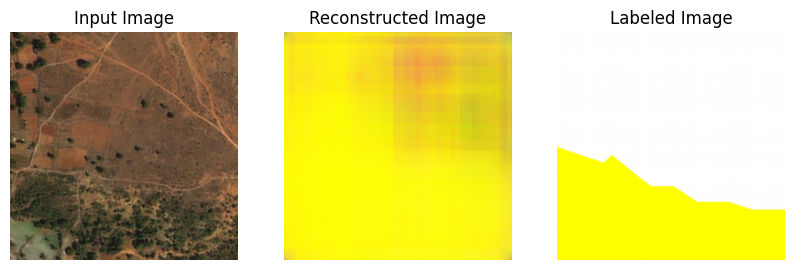

In [94]:
output_image(loaded_model, train_loader, device)